### Calulate ssh spectra at every grid point (Spatial structure of peaks)

In [5]:
import cmocean as cmo
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy import signal
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import xarray as xr
from xmitgcm import open_mdsdataset

In [ ]:
def create_nc_file(x_array, y_array, p1_psd, p2_psd, p3_psd, p1_freq, p2_freq, p3_freq, filename,
                   title, description, units1='psd', name1='PSD peak',units2='cpd', name2='frequency peak'):
    
    """ This function creates a netCDF4 file for
    the PSD and frequency of the 3 peaks in SSH spectra (Bay-No Bay FebTS). 
    
    :arg dist_array: np 2D array, distance from bay array from meshgrid
    :arg time_array: np 2D array, time array from meshgrid
    :arg curtain_data: np 2D array of data to plot in curtain hovmöller. Size is (len(dist_array),len(time_array))
    :arg filename: str, Directory and name of netcdf file
    :arg title: str, title of plot
    :arg description: str, Details about the data
    """
    dataset = Dataset(filename, 'w')
    file_x = dataset.createDimension('x', curtain_data.shape[1])
    file_t = dataset.createDimension('t', curtain_data.shape[0])

    file_X = dataset.createVariable('X', 'f8', ('x'))
    file_T = dataset.createVariable('T', 'f8', ('t'))
    curt_data = dataset.createVariable('curtain_data', 'f8', ('t','x'))

    dataset.title = title
    dataset.author = 'Karina Ramos Musalem'
    dataset.institution = 'ICACC-UNAM'
    dataset.source = '/notebooks/MITgcm/domain5/ssh_spectra_domain.ipynb'
    dataset.description = description
    dataset.timeStamp = time.ctime(time.time())
    file_X.standard_name = 'longitude'
    file_X.units = 'deg W'
    file_Y.standard_name = 'latitude'
    file_Y.units = 'deg N'
    file_p1_psd.standard_name = name1
    file_p1_psd.units = units1
    file_p2_psd.standard_name = name1
    file_p2_psd.units = units1
    file_p3_psd.standard_name = name1
    file_p3_psd.units = units1
    file_p1_freq.standard_name = name2
    file_p1_freq.units = units2
    file_p2_freq.standard_name = name2
    file_p2_freq.units = units2
    file_p3_freq.standard_name = name2
    file_p3_freq.units = units2
   
    
    file_X[:] = x_array[:]
    file_Y[:] = y_array[:]
    file_p1_psd[:] = p1_psd[:]
    file_p2_psd[:] = p2_psd[:]
    file_p3_psd[:] = p3_psd[:]
    file_p1_freq[:] = p1_freq[:]
    file_p2_freq[:] = p2_freq[:]
    file_p3_freq[:] = p3_freq[:]

    dataset.close()

In [7]:
outdir = '/data/SO2/sio-kramosmusalem/exp06_512x612x100_ORL_SVB/01_SVB_febTS_output/'
outdir2 = '/data/SO2/sio-kramosmusalem/exp06_512x612x100_ORL/01_noSVB_febTS/'

ds = open_mdsdataset(outdir, prefix=['eta'])
ds2 = open_mdsdataset(outdir2, prefix=['eta'])

In [34]:
LAT = ds2['YC'][:]
LON = ds2['XC'][:]-360
lat = ds2.YC[:,0].data
lon = ds2.XC[0,:].data-360

nx = len(lon)
ny = len(lat)

# centers mask
hFacC = ds2['hFacC'][:]
hfac = np.ma.masked_values(hFacC, 0)
mask = np.ma.getmask(hfac)

In [55]:
# This cell takes a veeeeeery long time to run. That is why we save the result in a nc file.
psd_p1 = np.zeros((ny,nx))*np.nan
freq_p1 = np.zeros((ny,nx))*np.nan
psd_p2 = np.zeros((ny,nx))*np.nan
freq_p2 = np.zeros((ny,nx))*np.nan
psd_p3 = np.zeros((ny,nx))*np.nan
freq_p3 = np.zeros((ny,nx))*np.nan

samp_freq = 1/600 # 10 min data
   
for ii in range(nx):
    if ii%10 == 0:
        print(ii)
    for jj in range(ny):
        if mask[0,jj,ii]== True:
            continue
        else:
            freq, psd = signal.periodogram(ds.ETAN[:,jj,ii], samp_freq, detrend='constant')
        
        psd_p1[jj,ii] = np.max(psd[17:23]) # find max PSD for peak 1 (these limits shouldn't be hard coded!)
        freq_p1[jj,ii] = freq[np.argmax(psd[17:23])+17]*86400 # find corresponding frequency
        
        psd_p2[jj,ii] = np.max(psd[25:31]) # find max PSD for peak 2
        freq_p2[jj,ii] = freq[np.argmax(psd[25:31])+25]*86400
        
        psd_p3[jj,ii] = np.max(psd[35:45]) # find max PSD for peak 3
        freq_p3[jj,ii] = freq[np.argmax(psd[35:45])+35]*86400

0
10


KeyboardInterrupt: 

In [ ]:
filename = 'ssh_spectra_3peaks_febTS.nc'
description = 'This file conains the PSD and frequency of the 3 peaks in SSH spectra (Bay-No Bay FebTS) at around 5.2 cpd, 7.6 cpd and 11.7 cpd on the whole domain.'
title = 'SSH max PSD and frequency of main peaks SVB-no SVB for FebTS runs '

create_nc_file(lon[:], lat[:], p1_psd, p2_psd, p3_psd, p1_freq, p2_freq, p3_freq, filename,
               title, description)

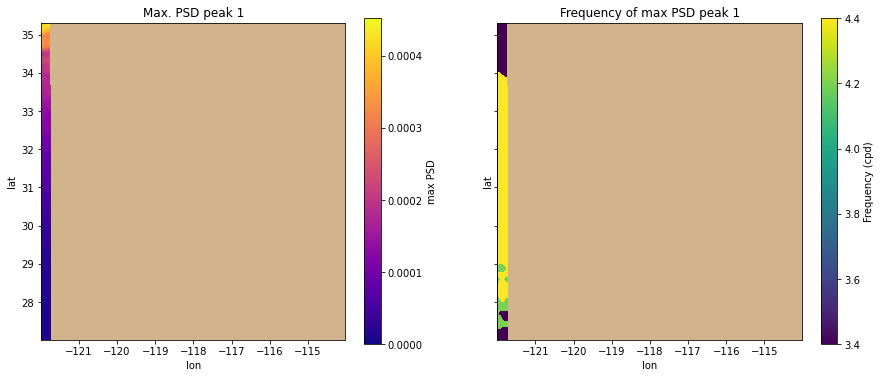

In [56]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,6), sharey=True)
ax1.set_facecolor('tan')
pc1 = ax1.pcolormesh(lon,lat, psd_p1, cmap='plasma')
plt.colorbar(pc1, ax=ax1, label='max PSD')
ax1.set_xlabel('lon')
ax1.set_ylabel('lat')
ax1.set_title('Max. PSD peak 1')
ax1.set_aspect(1)

ax2.set_facecolor('tan')
pc2 = ax2.pcolormesh(lon, lat, freq_p1, cmap='viridis')
plt.colorbar(pc2, ax=ax2, label='Frequency (cpd)')
ax2.set_xlabel('lon')
ax2.set_ylabel('lat')
ax2.set_title('Frequency of max PSD peak 1')
ax2.set_aspect(1)
